# Time Series Forecasting with Transformer in PyTorch
This notebook demonstrates how to use a simple Transformer architecture for time series forecasting using PyTorch.

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from data_utils import generate_sine_wave
from transformer_model import TimeSeriesTransformer

In [2]:
# Hyperparameters
SEQ_LENGTH = 20
NUM_SAMPLES = 1000
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.001

In [3]:
# Generate data
X, y = generate_sine_wave(SEQ_LENGTH, NUM_SAMPLES)
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [4]:
# Convert to tensors and create DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Model, optimizer, and loss function
model = TimeSeriesTransformer(input_size=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [6]:
# Training loop using DataLoader
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.7086
Epoch 2/20, Loss: 0.0662
Epoch 2/20, Loss: 0.0662
Epoch 3/20, Loss: 0.0599
Epoch 3/20, Loss: 0.0599
Epoch 4/20, Loss: 0.0619
Epoch 4/20, Loss: 0.0619
Epoch 5/20, Loss: 0.0593
Epoch 5/20, Loss: 0.0593
Epoch 6/20, Loss: 0.0595
Epoch 6/20, Loss: 0.0595
Epoch 7/20, Loss: 0.0582
Epoch 7/20, Loss: 0.0582
Epoch 8/20, Loss: 0.0574
Epoch 8/20, Loss: 0.0574
Epoch 9/20, Loss: 0.0588
Epoch 9/20, Loss: 0.0588
Epoch 10/20, Loss: 0.0575
Epoch 10/20, Loss: 0.0575
Epoch 11/20, Loss: 0.0577
Epoch 11/20, Loss: 0.0577
Epoch 12/20, Loss: 0.0568
Epoch 12/20, Loss: 0.0568
Epoch 13/20, Loss: 0.0563
Epoch 13/20, Loss: 0.0563
Epoch 14/20, Loss: 0.0578
Epoch 14/20, Loss: 0.0578
Epoch 15/20, Loss: 0.0583
Epoch 15/20, Loss: 0.0583
Epoch 16/20, Loss: 0.0574
Epoch 16/20, Loss: 0.0574
Epoch 17/20, Loss: 0.0561
Epoch 17/20, Loss: 0.0561
Epoch 18/20, Loss: 0.0598
Epoch 18/20, Loss: 0.0598
Epoch 19/20, Loss: 0.0554
Epoch 19/20, Loss: 0.0554
Epoch 20/20, Loss: 0.0544
Epoch 20/20, Loss: 0.0544


In [7]:
# Evaluation and prediction using DataLoader
model.eval()
preds = []
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_x)
        preds.append(output.cpu().numpy())
        true_vals.append(batch_y.cpu().numpy())
preds = np.concatenate(preds)
true_vals = np.concatenate(true_vals)
test_loss = criterion(torch.tensor(preds), torch.tensor(true_vals)).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0489


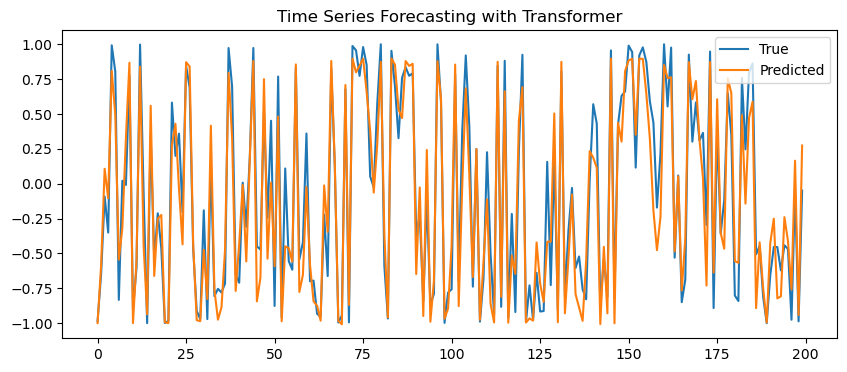

In [8]:
# Plot predictions
plt.figure(figsize=(10,4))
plt.plot(true_vals, label='True')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title('Time Series Forecasting with Transformer')
plt.show()

MAE: 0.1798
RMSE: 0.2212
R²: 0.8969


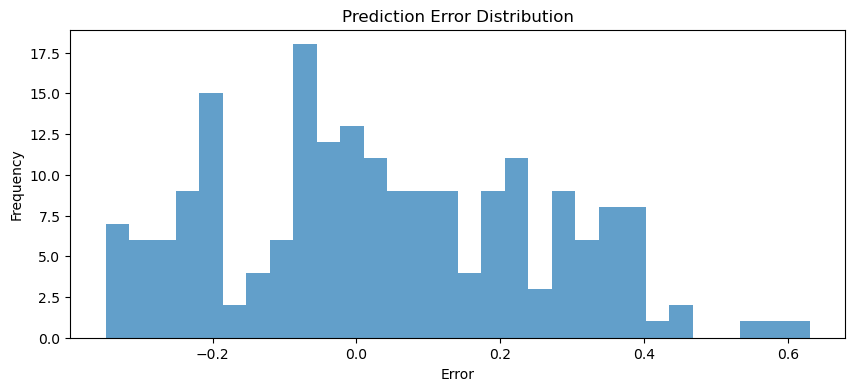

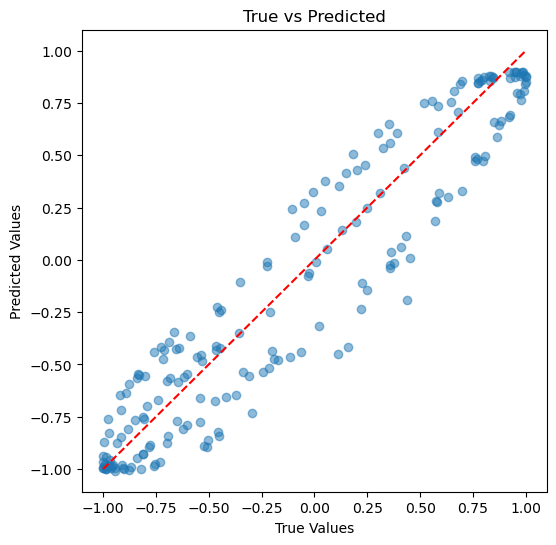

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate regression metrics
mae = mean_absolute_error(true_vals, preds)
rmse = np.sqrt(mean_squared_error(true_vals, preds))
r2 = r2_score(true_vals, preds)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot prediction errors
errors = true_vals - preds
plt.figure(figsize=(10,4))
plt.hist(errors, bins=30, alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Scatter plot: True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(true_vals, preds, alpha=0.5)
plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')
plt.show()

In [13]:
# Save the trained model
torch.save(model.state_dict(), "transformer_timeseries.pth")

# To load the model later
loaded_model = TimeSeriesTransformer(input_size=1).to(device)
loaded_model.load_state_dict(torch.load("transformer_timeseries.pth"))
loaded_model.eval()

TimeSeriesTransformer(
  (input_linear): Linear(in_features=1, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_linear): Linear(in_features=64, out_features=1, bias=True)
)